# 0 README

A Jupyter Notebook for comparing particle size distributions from the LISST-HOLO and UVP5 and UVP6

# 1.0 Setup
## 1.1 Module Import

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from glob import glob
from pathlib import Path
import re
from matplotlib.ticker import LogLocator, ScalarFormatter

## 1.2 Data Import

In [5]:
# Path to your folder
data_dir = Path("temp_data\export_raw_20260109_10_47_uvp6_dy180")

# Find all .tsv files
all_tsv_files = glob(str(data_dir / "*.tsv"))

# Exclude unwanted files
tsv_files = [
    f for f in all_tsv_files
    if "_black" not in f and "_summary" not in f
]

dfs = []

for f in tsv_files:
    fname = Path(f).name
    
    # Split filename on underscores
    parts = fname.split("_")
    
    sample_time = parts[0]   # '20240622-113827'
    cruise_id  = parts[1]    # 'dy180'
    cast_id    = parts[2]    # 'CTD053S'
    
    # Read data
    df = pd.read_csv(f, sep="\t")
    
    # Add metadata columns
    df["sample_time"] = sample_time
    df["cruise_id"] = cruise_id
    df["cast_id"] = cast_id
    
    dfs.append(df)

# Concatenate everything
DY180_UVP6_dat_raw = pd.concat(dfs, ignore_index=True)

data_dir = Path("temp_data\export_detailed_20260109_11_43_uvp6_dy180")

# Find all .tsv files
all_tsv_files = glob(str(data_dir / "*.tsv"))

# Exclude unwanted files
tsv_files = [
    f for f in all_tsv_files
    if "_black" not in f and "_summary" not in f
]

DY180_UVP6_dat_det = pd.read_csv(tsv_files[0], sep="\t", encoding='unicode_escape')


<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:38: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:38: SyntaxWarning: invalid escape sequence '\e'
C:\Users\hanshil\AppData\Local\Temp\ipykernel_1692\3643974660.py:2: SyntaxWarning: invalid escape sequence '\e'
  data_dir = Path("temp_data\export_raw_20260109_10_47_uvp6_dy180")
C:\Users\hanshil\AppData\Local\Temp\ipykernel_1692\3643974660.py:38: SyntaxWarning: invalid escape sequence '\e'
  data_dir = Path("temp_data\export_detailed_20260109_11_43_uvp6_dy180")


# 2.0 Data Processing
## 2.1 Pixel area to um conversion

In [ ]:
# Necessary for the _raw dataframe, _det is already in um units.

## 2.2 Plotting _det data

### 2.2.1 Helper functions for parsing column names

In [23]:


# --- helpers to parse LPM column names ---
_lpm_pat = re.compile(r"^LPM\s*\(([\d.]+)\s*-\s*([\d.]+)\s*µm\)\s*\[#\s*l-1\]\s*$")

def get_lpm_bin_info(columns):
    """
    Return a dataframe mapping LPM columns -> bin_low, bin_high, bin_mid, bin_width.
    Only keeps columns matching the LPM (...) [# l-1] pattern.
    """
    rows = []
    for c in columns:
        m = _lpm_pat.match(c)
        if m:
            lo = float(m.group(1))
            hi = float(m.group(2))
            rows.append((c, lo, hi, (lo + hi) / 2, (hi - lo)))
    out = pd.DataFrame(rows, columns=["col", "bin_low", "bin_high", "bin_mid", "bin_width"])
    return out.sort_values("bin_mid").reset_index(drop=True)


def psd_for_profile(
    df,
    profile_name,
    depth_range=None,
    depth_col="Depth [m]",
    profile_col="Profile",
    agg="mean",
    min_size_um=64.0,   # NEW
):
    sub = df.loc[df[profile_col] == profile_name].copy()
    if sub.empty:
        raise ValueError(f"No rows found for {profile_col} == {profile_name!r}")

    if depth_range is not None:
        dmin, dmax = depth_range
        sub = sub.loc[(sub[depth_col] >= dmin) & (sub[depth_col] <= dmax)].copy()
        if sub.empty:
            raise ValueError(f"No rows left after depth filter {depth_range} for profile {profile_name!r}")

    bin_info = get_lpm_bin_info(sub.columns)
    if bin_info.empty:
        raise ValueError("No LPM (X-X µm) [# l-1] columns found.")

    lpm_cols = bin_info["col"].tolist()
    sub[lpm_cols] = sub[lpm_cols].apply(pd.to_numeric, errors="coerce")

    if agg == "mean":
        abundance = sub[lpm_cols].mean(axis=0, skipna=True)
    elif agg == "median":
        abundance = sub[lpm_cols].median(axis=0, skipna=True)
    else:
        raise ValueError("agg must be 'mean' or 'median'")

    psd = bin_info.copy()
    psd["abundance_mean"] = psd["col"].map(abundance)
    psd["norm_abundance"] = psd["abundance_mean"] / psd["bin_width"]

    # ---- NEW: size cutoff ----
    psd = psd.loc[psd["bin_mid"] >= min_size_um].reset_index(drop=True)

    return psd[["bin_low", "bin_high", "bin_mid", "bin_width",
                "abundance_mean", "norm_abundance"]]



### 2.2.2 Plotting

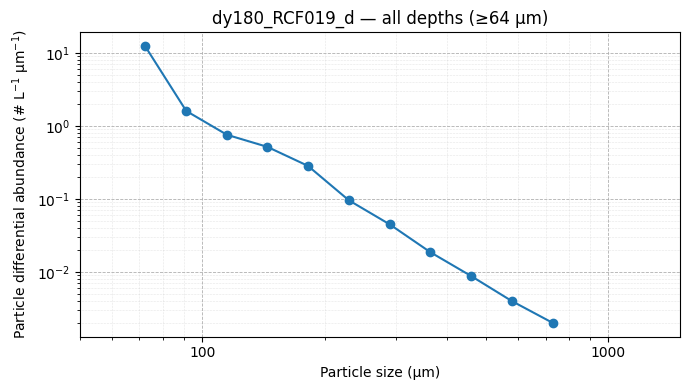

In [34]:
def plot_psd(psd, title=None):
    fig, ax = plt.subplots(figsize=(7, 4))

    ax.plot(
        psd["bin_mid"],
        psd["norm_abundance"],
        marker="o",
        linestyle="-"
    )

    ax.set_xlabel("Particle size (µm)")
    ax.set_ylabel("Particle differential abundance (# L$^{-1}$ µm$^{-1}$)")

    # Log–log axes
    ax.set_xscale("log")
    ax.set_yscale("log")

    # ---- Force x-axis range and ticks ----
    ax.set_xlim(50, 1500)

    ax.xaxis.set_major_locator(LogLocator(base=10, subs=(1.0,)))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs="auto"))

    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(plt.NullFormatter())

    if title:
        ax.set_title(title)

    ax.grid(True, which="major", linestyle="--", linewidth=0.6)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.4, alpha=0.6)

    plt.tight_layout()
    plt.show()



psd_all = psd_for_profile(
    DY180_UVP6_dat_det,
    "dy180_RCF019_d",
    depth_range=(200,500),
    min_size_um=64
)

plot_psd(psd_all, title="dy180_RCF019_d — all depths (≥64 µm)")

